In [0]:
import numpy as np
import matplotlib.pyplot as plt
from math import *

#Projet MC : simulation d'une épidémie

L'objet de ce sujet est d'implémenter le modèle SEIR stochastique présenté dans l'article : https://www.medrxiv.org/content/10.1101/2020.01.31.20019901v2


## 1) Simulation d'une épidémie avec le modele SEIR (continu), discrétisation,  estimation avec MC et réduction de variance 

In [0]:
class SEIR :
  """Simule, selon le modele SEIR adapté au covid19 en France, l'épidémie, les valeurs par défaut sont celles estimé sur la France"""
  def __init__( self,population=65000000,I0=100,gamma=1/2.9,sigma=1/5.2,a=0.4,tau_report=0.1, tau_hosp=0.1,tau_dc_hosp=1/6,nu=1/10):
    self.S=[population-I0]
    self.E_1=[0]
    self.E_2=[0]
    self.I_1=[I0]
    self.I_2=[0]
    self.H_1=[I0]
    self.H_2=[0]
    self.D=[0]
    self.DC=[0]
    self.HC=[0]
    self.B=[1]
    self.t=0
    self.a=a
    self.N=population
    self.tau_report= tau_report
    self.tau_hosp=tau_hosp
    self.tau_dc_hosp=tau_dc_hosp
    self.nu=nu
    self.sigma=sigma
    self.gamma=gamma
  
  def next_day(self,b):
    t=self.t
    self.t+=1
    # S contaminés par I_1+I_2
    self.S.append(max(0,self.S[t]-self.B[t]*self.S[t]*(self.I_1[t]+self.I_2[t])/self.N))# le max est du à la discretisation 

    # Erlang des E (temps d'incubation)
    self.E_1.append(self.E_1[t]+(self.S[t]-self.S[t+1]) -2*self.sigma*self.E_1[t])
    self.E_2.append(self.E_2[t]+2*self.sigma*self.E_1[t]-2*self.sigma*self.E_2[t])

    # Erlang des I (temps de contagion)
    self.I_1.append(self.I_1[t]+2*self.sigma*self.E_2[t]-2*self.gamma*self.I_1[t])
    self.I_2.append(self.I_2[t]+2*self.gamma*self.I_1[t]-2*self.gamma*self.I_2[t])
    self.D.append(self.D[t]+2*self.sigma*self.E_2[t]*self.tau_report) # nombre de personne cumulé ayant étaient testées positives  

    # Hospitalisation, temps d'hospitalisation et décès
    self.H_1.append(self.H_1[t]+2*self.tau_hosp*self.gamma*self.I_2[t]-2*self.nu*self.H_1[t])
    self.H_2.append(self.H_2[t]+2*self.nu*self.H_1[t]-2*self.nu*self.H_2[t])
    self.DC.append(self.DC[t]+2*self.tau_dc_hosp*self.nu*self.H_2[t])
    self.HC.append(self.HC[t]+2*self.tau_hosp*self.gamma*self.I_2[t])

    # nouveau Beta
    self.B.append(self.B[t]*exp(self.a*b)*exp(-(self.a)**2/2))

  def epidemie(self,n_days,b):
    """Simule une épidémie sur n_days jours, ayant comme perturbation le mouvement brownien b que l'on represente par 
    un array ou chaque la case t représente la différence de b entre t et t+1 (ordinairement une suite de loi normale centrée réduite)"""
    for t in range (n_days):
      self.next_day(b[t])
      


111.65996666481702

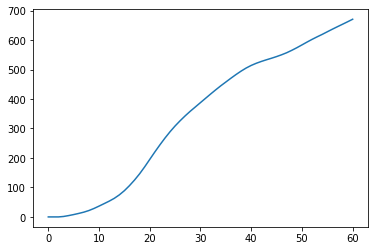

In [0]:
covid = SEIR()
b=np.random.normal(size=60)
covid.epidemie(60,b)
plt.plot(covid.D)
covid.DC[60]

In [0]:
def phi (b):
  covid = SEIR()
  covid.epidemie(len(b),b)
  return covid.D.pop()
phi(np.random.normal(size=60))

65.01886913177376

In [0]:
# classique MC :
def classiqueMC (n):
  lst= []
  for i in range (n):
    b = np.random.normal(size=60)
    lst.append(phi(b))
  V= np.array(lst)
  print("La moyenne est",V.mean(), " valeur donnée avec un ecart type de ", V.std()/sqrt(n))
classiqueMC(100)
classiqueMC(1000)
classiqueMC(10000)

La moyenne est 500182.93274278264  valeur donnée avec un ecart type de  167509.68874822103
La moyenne est 529896.7971685396  valeur donnée avec un ecart type de  51338.422182524584
La moyenne est 553478.7545142405  valeur donnée avec un ecart type de  16847.750843794056


In [0]:
def classiqueMC2 (n):
  lst= []
  for i in range (n):
    b = np.random.normal(size=60)
    lst.append((phi(b)+phi(-b))/2)
  V= np.array(lst)
  print("La moyenne est",V.mean(), " valeur donnée avec un ecart type de ", V.std()/sqrt(n))
classiqueMC2(50)
classiqueMC2(500)
classiqueMC2(5000)
classiqueMC2(50000)

La moyenne est 575624.0025399954  valeur donnée avec un ecart type de  155457.11919920368
La moyenne est 489210.25359726703  valeur donnée avec un ecart type de  47002.00399084201
La moyenne est 533323.3332535803  valeur donnée avec un ecart type de  15715.086352389471
La moyenne est 537037.0193494905  valeur donnée avec un ecart type de  4976.3015730345005


On ajoute des variables de contrôles dans le but de réduire la variance de notre estimmateur.
On prend comme variables de contrôles les n normales centrées réduites utilisées pour construire le mouvement brownien B


In [0]:
def MC_controlvariates (n,m = 60):
  lst= []
  LST2= []
  Cov = np.zeros(m)
  S = np.zeros((n,1))
  b = np.random.normal(size =(n,m))
  for i in range (n):
    lst.append((phi(b[i,:])+phi(-b[i,:]))/2)
  V= np.array(lst)
  M= V.mean()
  for j in range (m) : 
    for i in range(n):
      Cov[j]+=(1/n)*(V[i]-M)*b[i,j]  
#On calcule la covariance entre b[:,j] et lst
    S = S + Cov[j]*b[:,j]
  print (b[:,4].mean()) #je verifie que les b[:,j] sont sans biais
  for p in range (n):
    LST2.append(lst[p] - S[p])
  W= np.array(LST2)
# le variance de bi est égal à i
# covariance de phi(b) et b[i] doit etre calculée de maniere empirique, elle est égale à l'esperance de (phi-M)*b[i] puisque E[b[i]]=0
  
  
  print("La moyenne est",W.mean(), " valeur donnée avec un ecart type de ", W.std()/sqrt(n))
MC_controlvariates(50)
MC_controlvariates(500)
MC_controlvariates(5000)

0.03595754495477019
La moyenne est 830370.1519059247  valeur donnée avec un ecart type de  319419.4463420215
0.031120825577921573
La moyenne est 559830.656459909  valeur donnée avec un ecart type de  54318.80887754156
0.007077259513126669
La moyenne est 528804.8732247044  valeur donnée avec un ecart type de  15635.253458364952


L'algorithme ne donne pas de meilleurs résultats que l'algorithme de MC classique

## 2) Approche (R)QMC et ses conséquences sur la simulation 

Le but de cette partie est de faire du RQMC avec différentes construction du mouvement brownien. 

D'abort il s'agit de creer une série de loi normale à partir de loi uniforme. Pour cela on utilise Box Muller:

(array([ 1.,  0.,  1.,  2.,  1.,  6.,  6.,  4., 11.,  7., 24., 19., 21.,
        36., 40., 39., 58., 58., 43., 68., 65., 52., 58., 63., 75., 52.,
        37., 42., 19., 20., 13., 15., 10., 11.,  8.,  4.,  6.,  2.,  1.,
         2.]),
 array([-3.43188867e+00, -3.26844918e+00, -3.10500969e+00, -2.94157020e+00,
        -2.77813071e+00, -2.61469122e+00, -2.45125173e+00, -2.28781224e+00,
        -2.12437275e+00, -1.96093326e+00, -1.79749377e+00, -1.63405428e+00,
        -1.47061479e+00, -1.30717530e+00, -1.14373580e+00, -9.80296315e-01,
        -8.16856825e-01, -6.53417335e-01, -4.89977845e-01, -3.26538355e-01,
        -1.63098865e-01,  3.40625555e-04,  1.63780116e-01,  3.27219606e-01,
         4.90659096e-01,  6.54098586e-01,  8.17538076e-01,  9.80977566e-01,
         1.14441706e+00,  1.30785655e+00,  1.47129604e+00,  1.63473553e+00,
         1.79817502e+00,  1.96161451e+00,  2.12505400e+00,  2.28849349e+00,
         2.45193298e+00,  2.61537247e+00,  2.77881196e+00,  2.94225145e+00,
      

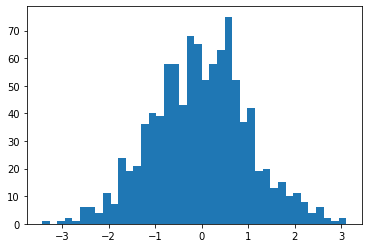

In [0]:
def boxMuller (U):
  """gènère à partir de 2*k loi uniforme, 2*k normales avec box muller"""
  k = len (U)//2
  res=[]
  for i in range (k):
    res.append(sqrt(-2*log(U[2*i]))*cos(2*pi*U[2*i+1]))
    res.append(sqrt(-2*log(U[2*i]))*sin(2*pi*U[2*i+1]))
  return np.array(res)
b =boxMuller(np.random.random(size=1000))
plt.hist(b,40)

Une fois notre série de normale généré, il s'agit de l'utiliser pour creer un mouvement Brownien. 

Pour cela on va procéder de deux manière : 
1. On utilise $B_{t+1}-B_{t}$ est une loi normale centrée réduite conditionellement à $\mathcal{F_t}$ (l'information disponible au temps $t$)
1. On utilise la propriétée du pont brownien, on construit le mouvement en commençant par les extrémitées


La premiere méthode est déja codé implicitement dans la partie précédente. Codons la deuxieme méthode

[0. 1. 2. 1. 2. 2. 3. 1. 2. 3. 2. 3. 3. 4. 1. 2. 3. 2. 3. 3. 4. 2. 3. 3.
 4. 3. 4. 4. 5. 0.]


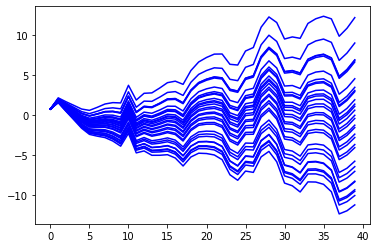

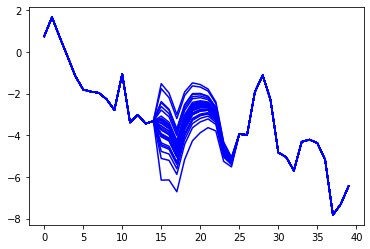

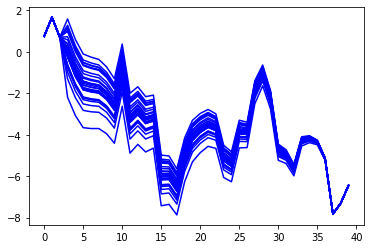

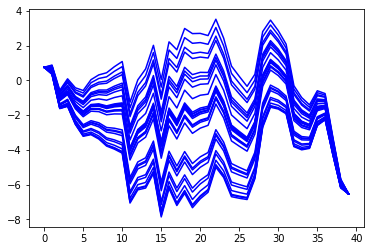

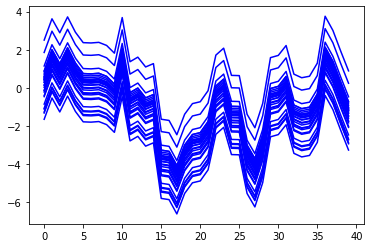

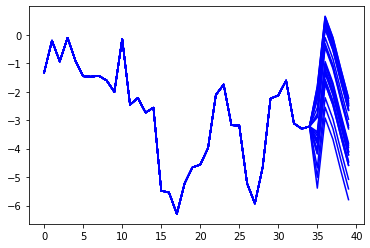

In [0]:
def bronwianBridge(Bi,Bj,i,j,N,k):
  """construit la valeur B_k """
  m= ((k-i)*Bj+(j-k)*Bi)/(j-i)
  v= ((k-i)*(j-k))/(j-i)
  return m+sqrt(v)*N


def constructionBridge(lst_normal): 
  k = len(lst_normal)//2
  res= np.zeros(2*k)
  res[0]= lst_normal[0]
  res[2*k-1]= sqrt(2*k-1)*lst_normal[2*k-1]
  for i in range(1,k):
    res[i]= bronwianBridge(res[i-1],res[2*k-i],i-1,2*k-i,lst_normal[i],i)
    res[2*k-i-1]=bronwianBridge(res[i],res[2*k-i],i,2*k-i,lst_normal[2*k-i-1],2*k-i-1)
  
  return res 

def BridgeDichoRec(lst_normal,Bi,Bj,i,j):
  if j-i>1 :
    k = (i+j)//2
    Bk=bronwianBridge(Bi,Bj,i,j,lst_normal[k],k)
    return  BridgeDichoRec(lst_normal,Bi,Bk,i,k)+[Bk]+BridgeDichoRec(lst_normal,Bk,Bj,k,j)
  else :
    return []

def BridgeDicho(lst_normal):
  n= len(lst_normal)
  B0= lst_normal[0]
  Bn=sqrt(n)*lst_normal[n-1]
  return [B0]+BridgeDichoRec(lst_normal,B0,Bn,0,n-1)+[Bn]

def rang(lst,i,j):
  if j-i>1 :
    k = (i+j)//2
    lst[k]= lst[i]+1
    rang(lst,i,k)
    rang(lst,k,j)

lst=np.zeros(30)
rang(lst,0,29)
print(lst)

def constructionClassique (b):
  res=[]
  S=0
  for c in b:
    S+=c
    res.append(S)
  return np.array(res)


# pour tester on trace : 
#les mouvements bronwien en faisant varier que la derniere composante 
b =boxMuller(np.random.random(size=40))

for i in range (30):
  b[39]= np.random.normal()
  plt.plot(constructionBridge(b),'b')
plt.show()

#les mouvements bronwien en faisant varier que la 15 eme composante

for i in range (30):
  b[15]= np.random.normal()
  plt.plot(constructionBridge(b),'b')
plt.show()

#les mouvements bronwien en faisant varier que la 3 eme composante

for i in range (30):
  b[3]= np.random.normal()
  plt.plot(constructionBridge(b),'b')
plt.show()

for i in range (30):
  b[19]= np.random.normal()

  plt.plot(BridgeDicho(b),'b')
plt.show()

for i in range (30):
  b[0]= np.random.normal()

  plt.plot(constructionClassique(b),'b')
plt.show()

for i in range (30):
  b[35]= np.random.normal()

  plt.plot(constructionClassique(b),'b')
plt.show()


L'idée maintenant est de tester une méthode de RQMC (sur les lois uniforme qu'ont utilise pour genérérer les lois normales). 

On va utiliser une séquence de Halton :




[2, 3, 5, 7, 11, 13, 17, 19, 23, 29]
[[0.5        0.33333333]
 [0.25       0.66666667]
 [0.75       0.11111111]
 [0.125      0.44444444]
 [0.625      0.77777778]
 [0.375      0.22222222]
 [0.875      0.55555556]
 [0.0625     0.88888889]
 [0.5625     0.03703704]
 [0.3125     0.37037037]]


Text(0.5, 1.0, 'répartition de la séquence de Halton en dimension 2')

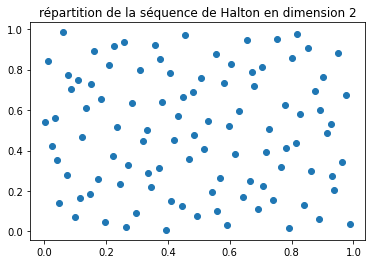

In [0]:
def lstPremier(d):
  #genere les d premiers premier
  res=[2]
  i=3
  while len(res)<d:
    if sum ([(i%c==0) for c in res])==0:
      res.append(i)
    i+=1
  return res

print(lstPremier(10))
def vdc(n, base=2):
    vdc, denom = 0, 1
    while n:
        denom *= base
        n, remainder = divmod(n, base)
        vdc += remainder/float(denom)
    return vdc
def halton (n,d):
  prem=lstPremier(d)
  return np.array([[vdc(i,b) for b in prem]for i in range(1,n+1)])

def halton2 (n,d):
  # addapter au pont B dicho 
  lst=np.zeros(d)
  rang(lst,0,d-1)
  l=np.argsort(-lst)
  prem=lstPremier(d)
  prem2=[prem[l[i]] for i in range(d)]
  return np.array([[vdc(i,b) for b in prem]for i in range(1,n+1)])

print(halton (10,2))
X= halton (100,2)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(X[:,1],X[:,0])
ax.set_title('répartition de la séquence de Halton en dimension 2')


In [0]:
def QMC (n,m=60):
  U = halton(n,m)
  res=0
  for i in range(n):
    b=boxMuller (U[i,:])
    res+= phi(b)
  return res/n
QMC(256)

1927373.4604844449

In [0]:
def RQMC_classique(n,m=60):
  V= halton(n,60)
  W= np.random.random(size=m)
  res=0
  for i in range(n):
    Ui=np.array([c-int(c>1)for c in(V[i,:]+W)]) 
    b=boxMuller (Ui)
    res+= phi(b)
  return res/n

V= np.array([RQMC_classique(100) for i in range(100)])
print("Le resultat est",V.mean(), " valeur donnée avec un ecart type de ", V.std()/sqrt(len(V)))

Le resultat est 579885.1905741801  valeur donnée avec un ecart type de  32634.76032452209


In [0]:
def transfo(b):
  res=[0]
  for i in range (1,len(b)):
    res.append(b[i]-b[i-1])
  return (np.array(res))
def RQMC_BB(n,m=60):
  V= halton(n,60)
  W= np.random.random(size=m)
  res=0
  for i in range(n):
    Ui=np.array([c-int(c>1)for c in(reversed(V[i,:]+W))]) 
    b=boxMuller (Ui)
    res+= phi(transfo(constructionBridge(b)))
  return res/n

V= np.array([RQMC_BB(100) for i in range(1000)])
print("Le resultat est",V.mean(), " valeur donnée avec un ecart type de ", V.std()/sqrt(len(V)))

Le resultat est 490282.5699083347  valeur donnée avec un ecart type de  11095.458528326755


In [0]:
def RQMC_BB2(n,m=60):
  V= halton(n,60)
  W= np.random.random(size=m)
  res=0
  for i in range(n):
    Ui=np.array([c-int(c>1)for c in(reversed(V[i,:]+W))]) 
    b=boxMuller (Ui)
    res+= phi(transfo(BridgeDicho(b)))
  return res/n
V= np.array([RQMC_BB2(100) for i in range(1000)])
print("Le resultat est",V.mean(), " valeur donnée avec un ecart type de ", V.std()/sqrt(len(V)))

Le resultat est 507309.0468404522  valeur donnée avec un ecart type de  9288.548047700577


In [0]:
x=[]
y=[]
n= [100+100*i for i in range(10)]
#for i in n: 
#  V1= np.array([RQMC_BB(281) for i in range(50)])
#  V2= np.array([RQMC_BB(281) for i in range(50)])
#  x.append(V1.std()/sqrt(len(V1)))
#  y.append(V2.std()/sqrt(len(V2)))
#plt.plot(n,x)
#plt.plot(n,y)

## 3) ABC pour estimer les parametres, comparaison avec les données françaises

In [0]:
import pandas as pd
import csv
import urllib

url = "https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7"
webpage = urllib.request.urlopen(url)
df= pd.read_csv(webpage,sep=';')
df


,dep,sexe,jour,hosp,rea,rad,dc
0,01,0,2020-03-18,2,0,1,0
1,01,1,2020-03-18,1,0,1,0
2,01,2,2020-03-18,1,0,0,0
3,02,0,2020-03-18,41,10,18,11
4,02,1,2020-03-18,19,4,11,6
...,...,...,...,...,...,...,...
18784,974,1,2020-05-19,10,3,56,0
18785,974,2,2020-05-19,2,0,59,0
18786,976,0,2020-05-19,53,12,184,18
18787,976,1,2020-05-19,31,5,91,12


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


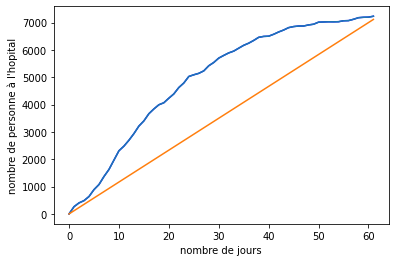

In [0]:
import numpy as np 
grouped = df[df['dep']=='69'].groupby('jour')
#grouped = df.groupby('jour')
df2= grouped['hosp','dc','rad'].agg(np.sum)
hc1= np.array(df2['hosp']+df2['dc']+df2['rad'] )
hc = hc1 -hc1[0]*np.ones((len(hc1)))
plot = plt.figure()  
ax = plot.add_subplot(111) 
plt.plot (hc,'b' )
ax.set_xlabel('nombre de jours', fontsize=10)
ax.set_ylabel("nombre de personne à l'hopital", fontsize=10)
plt.plot (hc)
j=len(hc)
plt.plot([max(hc)/j*i for i in range(j)])

In [0]:
url = "https://www.data.gouv.fr/fr/datasets/r/b4ea7b4b-b7d1-4885-a099-71852291ff20"
webpage = urllib.request.urlopen(url)
df= pd.read_csv(webpage,sep=';')
grouped = df.groupby('jour')
df_test= grouped['nb_test','nb_pos'].agg(np.sum)
df_test



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


,nb_test,nb_pos
jour,,
2020-03-10,158,16
2020-03-11,216,32
2020-03-12,313,66
2020-03-13,700,122
2020-03-14,334,108
...,...,...
2020-05-12,20593,331
2020-05-13,19010,284
2020-05-14,17937,290


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


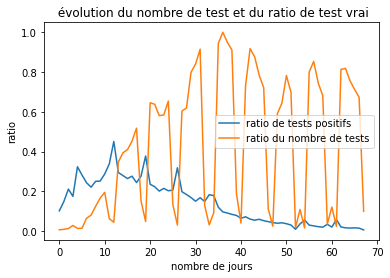

In [0]:
n= len(df_test)
plot = plt.figure()
plt.plot ([i for i in range (n)],df_test['nb_pos']/df_test['nb_test'],label='ratio de tests positifs')
plt.plot ([i for i in range (n)],df_test['nb_test']/max(df_test['nb_test']),label='ratio du nombre de tests')
ax = plot.add_subplot(111) 
ax.set_xlabel('nombre de jours', fontsize=10)
ax.set_ylabel("ratio", fontsize=10)
ax.set_title(" évolution du nombre de test et du ratio de test vrai")
plt.legend(loc='best')


Interprétation des anomalies statistiques: les pic sont du au fait que les labos test moins le we et test que les personnes avec beaucoup de symptome.  

On va faire de l'abc sur le nombre d'hospitalisation cumulé pour deux raisons : 
1. moins de parametres à feat (a,tau_hosp et eventuellement le nombre d'infections initiales) 
2. moins de perturbation hebdomadaire que le nombre de cas confirmée (le  week-end n'agit pas sur les hospitalisations)

[0, 206.89655172413796, 413.79310344827593, 577.1643584592045, 713.5199120619343, 871.3905339879361, 1092.6591904972465, 1398.562902580803, 1805.9273498796601, 2347.030117353466, 3115.8118605916256, 4211.988869810568, 5818.831175429836, 8149.73640954933, 11457.867934178179, 16258.015671010799, 23107.014005737805, 31658.685878253098, 40776.55378602512, 49309.607663428964, 56585.746719283496, 62397.40842350714, 66827.45161695946, 70090.77396102526, 72433.71390573485, 74082.98114114629, 75226.08569978051, 76008.58118486579, 76538.81915039268, 76895.10965798583, 77132.82742048276, 77290.47872133822, 77394.48851716385, 77462.7985432435, 77507.48417447023, 77536.61301438206, 77555.54153339968, 77567.8071349441, 77575.73506425512, 77580.84755447012, 77584.13755745543, 77586.2507009599, 77587.60557468483, 77588.47286788616, 77589.02721739889, 77589.38105132681, 77589.60660806177, 77589.7502200706, 77589.8415553771, 77589.89958244923, 77589.93641186571, 77589.9597656291, 77589.97456148786, 7758

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


Text(0.5, 1.0, " évolution du nombre total de personne admis à l'hopital depuis le 19 mars")

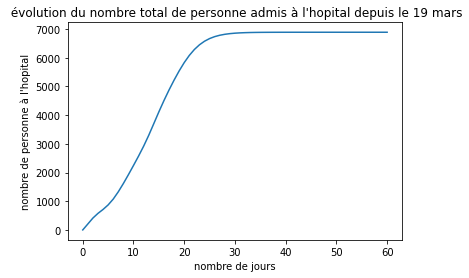

In [38]:
def y (a):
  covid = SEIR(a=a,population=764000)
  covid.E_1[0]=3000
  covid.E_2[0]=3000
  covid.I_1[0]=3000
  covid.I_2[0]=3000
  b = np.random.random(size = 60)
  covid.epidemie(60,b)
  return (covid.HC) 


print(y(0.4))
plot = plt.figure()  
plt.plot(y(1.4)) 
ax = plot.add_subplot(111) 
ax.set_xlabel('nombre de jours', fontsize=10)
ax.set_ylabel("nombre de personne à l'hopital", fontsize=10)
ax.set_title(" évolution du nombre total de personne admis à l'hopital depuis le 19 mars")



  

In [0]:
def ABC(y_a,loi_prior,comp,n,epsilon):
  L = []
  for i in range (n):
    a = loi_prior() # de preference une loi avec une grande variance
    y_simul = y_a(a) # y(a) est sensé renvoyé une liste du nombre de personne hospitalisé(en cumulé) depuis 32 jours
    y_vraie = hc
    if np.linalg.norm(comp(y_vraie) - comp(y_simul)) < epsilon:
        L.append(a)
    V = np.array(L)
  print ("la moyenne des paramètres acceptés est",V.mean(),"taux d'acceptation",len(V)/n)
  return (V)                   

  

In [0]:
def loi_prior():# on cree une loi normale tronquée
  a = np.random.normal(0.4,1) #on prend une variance arbitrairement grande 
#pour être sûr que des a générées permettent de faire coincider les données avec les simulations
# moyenne de la loi a priori égal au a trouvé par le papier sur le covid à Wuhan
  if a <=0 :
    return loi_prior() 
  else :
    return a


#nouvelle loi de moyenne 1.2(la moyenne des paramètres acceptés)
def loi_prior2():
  a = np.random.normal(1.2,1) #on reduit la variance de maniere arbitraire pour
  #obtenir un meilleur taux d'acceptation
  if a <=0 :
    return loi_prior2() 
  else :
    return a


def loi_posterior():
  a = np.random.normal(1.3,1)
  if a <=0 :
    return loi_posterior() 
  else :
    return a

def identite(x):
  return x[0:32]

def s (x):
  return np.array([x[5],x[10],x[15],x[20],x[25],x[30]])

la moyenne des paramètres acceptés est 1.175066311348357 taux d'acceptation 0.00702
la moyenne des paramètres acceptés est 1.2810247362529759 taux d'acceptation 0.03667
la moyenne des paramètres acceptés est 1.2877447442613077 taux d'acceptation 0.03593


Text(0.5, 1.0, 'loi normale N(1.3, 1)')

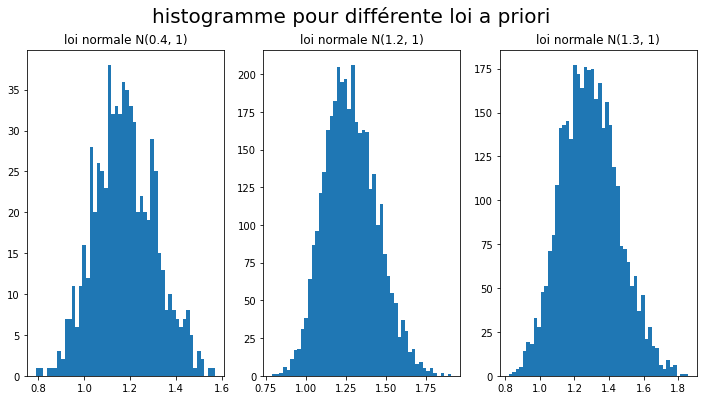

In [40]:
fig, ax = plt.subplots(1,3, figsize=(12,6))
fig.suptitle('histogramme pour différente loi a priori',fontsize=20)
type(fig)
plot1 = plt.figure(1)
plt.subplot(131)
plt.hist(ABC(y,loi_prior,identite,100000,1500),50)
plt.title("loi normale N(0.4, 1)")
plt.subplot(132)

plt.hist(ABC(y,loi_prior2,s,100000,1500),50)
plt.title("loi normale N(1.2, 1)")
plt.subplot(133)

plt.hist(ABC(y,loi_posterior,s,100000,1500),50)
plt.title("loi normale N(1.3, 1)")


Text(0.5, 1.0, 'simulation pour a=1.39')

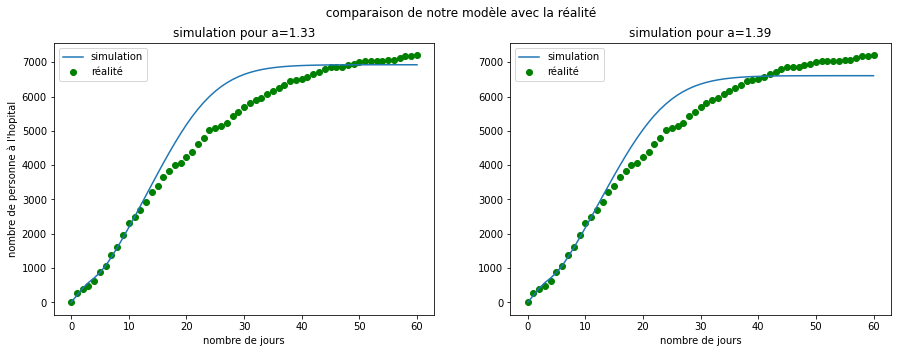

In [46]:
a_hat=1.33
h_simul=np.array(y(a_hat))
n= len(h_simul)
for i in range (10000):
  h_simul+= np.array(y(a_hat))

a_hat2=1.34
h_simul2=np.array(y(a_hat2))
n= len(h_simul2)
for i in range (10000):
  h_simul2+= np.array(y(a_hat2))


plot = plt.figure(figsize=(15,5))
plot.suptitle(" comparaison de notre modèle avec la réalité")
ax = plot.add_subplot(121)  
plt.plot([i for i in range(n)],h_simul/10001,label="simulation")
plt.scatter([i for i in range(n)],hc[0:n],c='g',label="réalité")
plt.legend(loc='best')
ax.set_xlabel('nombre de jours', fontsize=10)
ax.set_ylabel("nombre de personne à l'hopital", fontsize=10)
ax.set_title('simulation pour a=1.33')

ax2= plot.add_subplot(122)  
plt.plot([i for i in range(n)],h_simul2/10001,label="simulation")
plt.scatter([i for i in range(n)],hc[0:n],c='g',label="réalité")
plt.legend(loc='best')
ax2.set_xlabel('nombre de jours', fontsize=10)
ax2.set_title('simulation pour a=1.39')

On arrive pas à faire correspondre exactement les deux courbes, il faut faire des inférences également sur
 les autres paramètre du modèle. 

## 4) Prolongement, réflexion : modele SEIR discret
 
Ici, on a repris le modèle SEIR à l'origine continue pour en faire queqlque chose de plus discret. Cela a surtout pour but de mieux expliquer les debuts d'épidémie (plus granulaire ou l'hypothése de contuinité est pas forcémement réaliste). 
Le modele simule le comportement de chaque individu :
* les S peuvent se faire contaminer 
* Chaque E+I peuvent rencontrer selon une loi de poisson de moyenne $\lambda_r$ personnes par jours, puis avec une proba $\tau_c$ les contaminer 
* Le temps d'attente entre E et I est une loi exponentielle (d'ou l'Erlang en modele continue) 


In [0]:
class SimuPandemie:
    def __init__(self,population=65000000,I0=100,gamma=1/2.9,sigma=1/5.2,
                 tau_report=0.1, taux_hosp=0.1,tau_dc_hosp=1/6,nu=1/10,
                 lambda_rencontre=0.3, taux_contagion=1/6):
        self.l_rencontre =lambda_rencontre
        self.t_contagion =taux_contagion
        self.t_hosp =taux_hosp
        self.sigma=sigma
        self.gamma=gamma
        self.pop= population
        self.l_guerison = nu
        self.S=[population-I0]
        self.E=[0]
        self.I=[I0]
        self.H=[0]
        self.DC=[0]
        self.t=0

    def contamine(self,N):
        """ contamine potentiellement N personnes"""
        for j in range(N):
            if self.t_contagion < np.random.random(): 
                c= np.random.randint(self.pop)
                if self.people[c]==0 : 
                    self.people[c]=1
    
    def nextday(self): 
      #nouveaux infectés potentiel
      t=self.t 
      Itp=np.random.poisson(self.I[t]*self.l_rencontre)
      It= min(np.random.binomial(Itp,self.t_contagion),self.pop)
      if It>0:
          nIt = np.random.binomial(It,self.S[t]/self.pop)
      else:
          nIt=0
      EtoI=np.random.binomial(self.E[t],self.sigma)
      ItoRorH= np.random.binomial(self.I[t],self.gamma)
      ItoH= np.random.binomial(ItoRorH,self.t_hosp)
      self.S.append(max(self.S[t]- nIt,0))
      self.E.append(self.E[t]-EtoI+nIt)
      self.I.append(self.I[t]+EtoI-ItoRorH)
      self.H.append(self.H[t]+ItoH)
      self.t+=1
    
    def epidemie(self,lst_lr):
      for c in lst_lr:
        self.l_rencontre=c
        self.nextday()

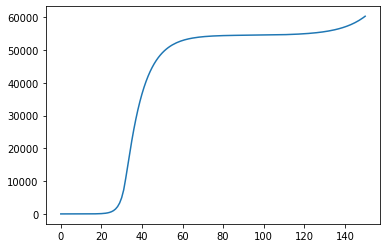

In [0]:
res=np.zeros(151)
for i in range(1000):

  covid2= SimuPandemie (I0=10,taux_hosp=0.01,taux_contagion=0.1,gamma=1/2.8)
  covid2.epidemie([30 for i in range(30)]+[1.1 for i in range(60)]+[7 for i in range(60)])
  res+=np.array(covid2.H)/1000
#plt.plot(covid1.H[])

#plt.plot (hc1)
j=len(hc)
#plt.plot([max(hc)/j*i for i in range(j)])
plt.plot(res)

In [0]:
res=[]
for i in range (1000):
  covid1= SimuPandemie (I0=1000)
  covid1.epidemie([5 for i in range(30)]+[0.3 for i in range(60)])
  res.append(covid1.H[60])
v= np.array(res)
print("valeur :",v.mean(),"ecart type :", v.std()/sqrt(1000) )


valeur : 13058.801 ecart type : 16.834945423107257
